In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs
import cv2
from cv2 import Mat
import math
import random
from IPython.display import Image, display
from PIL import Image as im

In [84]:
class TransferedPicture: #画像の相似変換
    def __init__(self,pic:Mat,scale,theta,gray=False):
        self.orig_img=pic
        if gray==False:
            h,w,c=self.orig_img.shape
        else:
            h,w=self.orig_img.shape
        mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale) #相似変換のパラメータ設定
        self.img = cv2.warpAffine(pic, mat, (w, h)) #相似変換を実行
        self.scale=scale
        self.theta=theta
    
    def write(self,img_name):
        cv2.imwrite(img_name,self.img)
        
    def get_img_array(self): #オリジナル画像と変換後画像の配列を得る
        return self.orig_img, self.img
    
    def get_gray_array(self): #オリジナル画像と変換後画像のグレースケールでの配列を得る
        orig_gray=cv2.cvtColor(self.orig_img,cv2.COLOR_BGR2GRAY)
        img_gray=cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        return orig_gray,img_gray
    
    def smooth_def(self): #x方向,y方向それぞれの平滑微分画像を生成
        #x方向の平滑微分画像
        gs_x=cv2.GaussianBlur(self.img,(3,3),3)
        kernel_x = 0.5 * np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
        dst_x = cv2.filter2D(gs_x, -1, kernel_x)
        
        #y方向の微分
        gs_y=cv2.GaussianBlur(self.img,(3,3),3)
        kernel_y = 0.5 * np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
        dst_y = cv2.filter2D(gs_y, -1, kernel_y)
        
        return dst_x,dst_y

In [3]:
def imshow(img):
    #ndarray 配列から画像をNotebook上に表示
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [4]:
#I'の計算
h,w,c=st_array.shape
mat = cv2.getRotationMatrix2D((w / 2, h / 2), -1*theta, 1/scale)
i_dash= cv2.warpAffine(st_array, mat, (w, h))
i_dash.shape

NameError: name 'st_array' is not defined

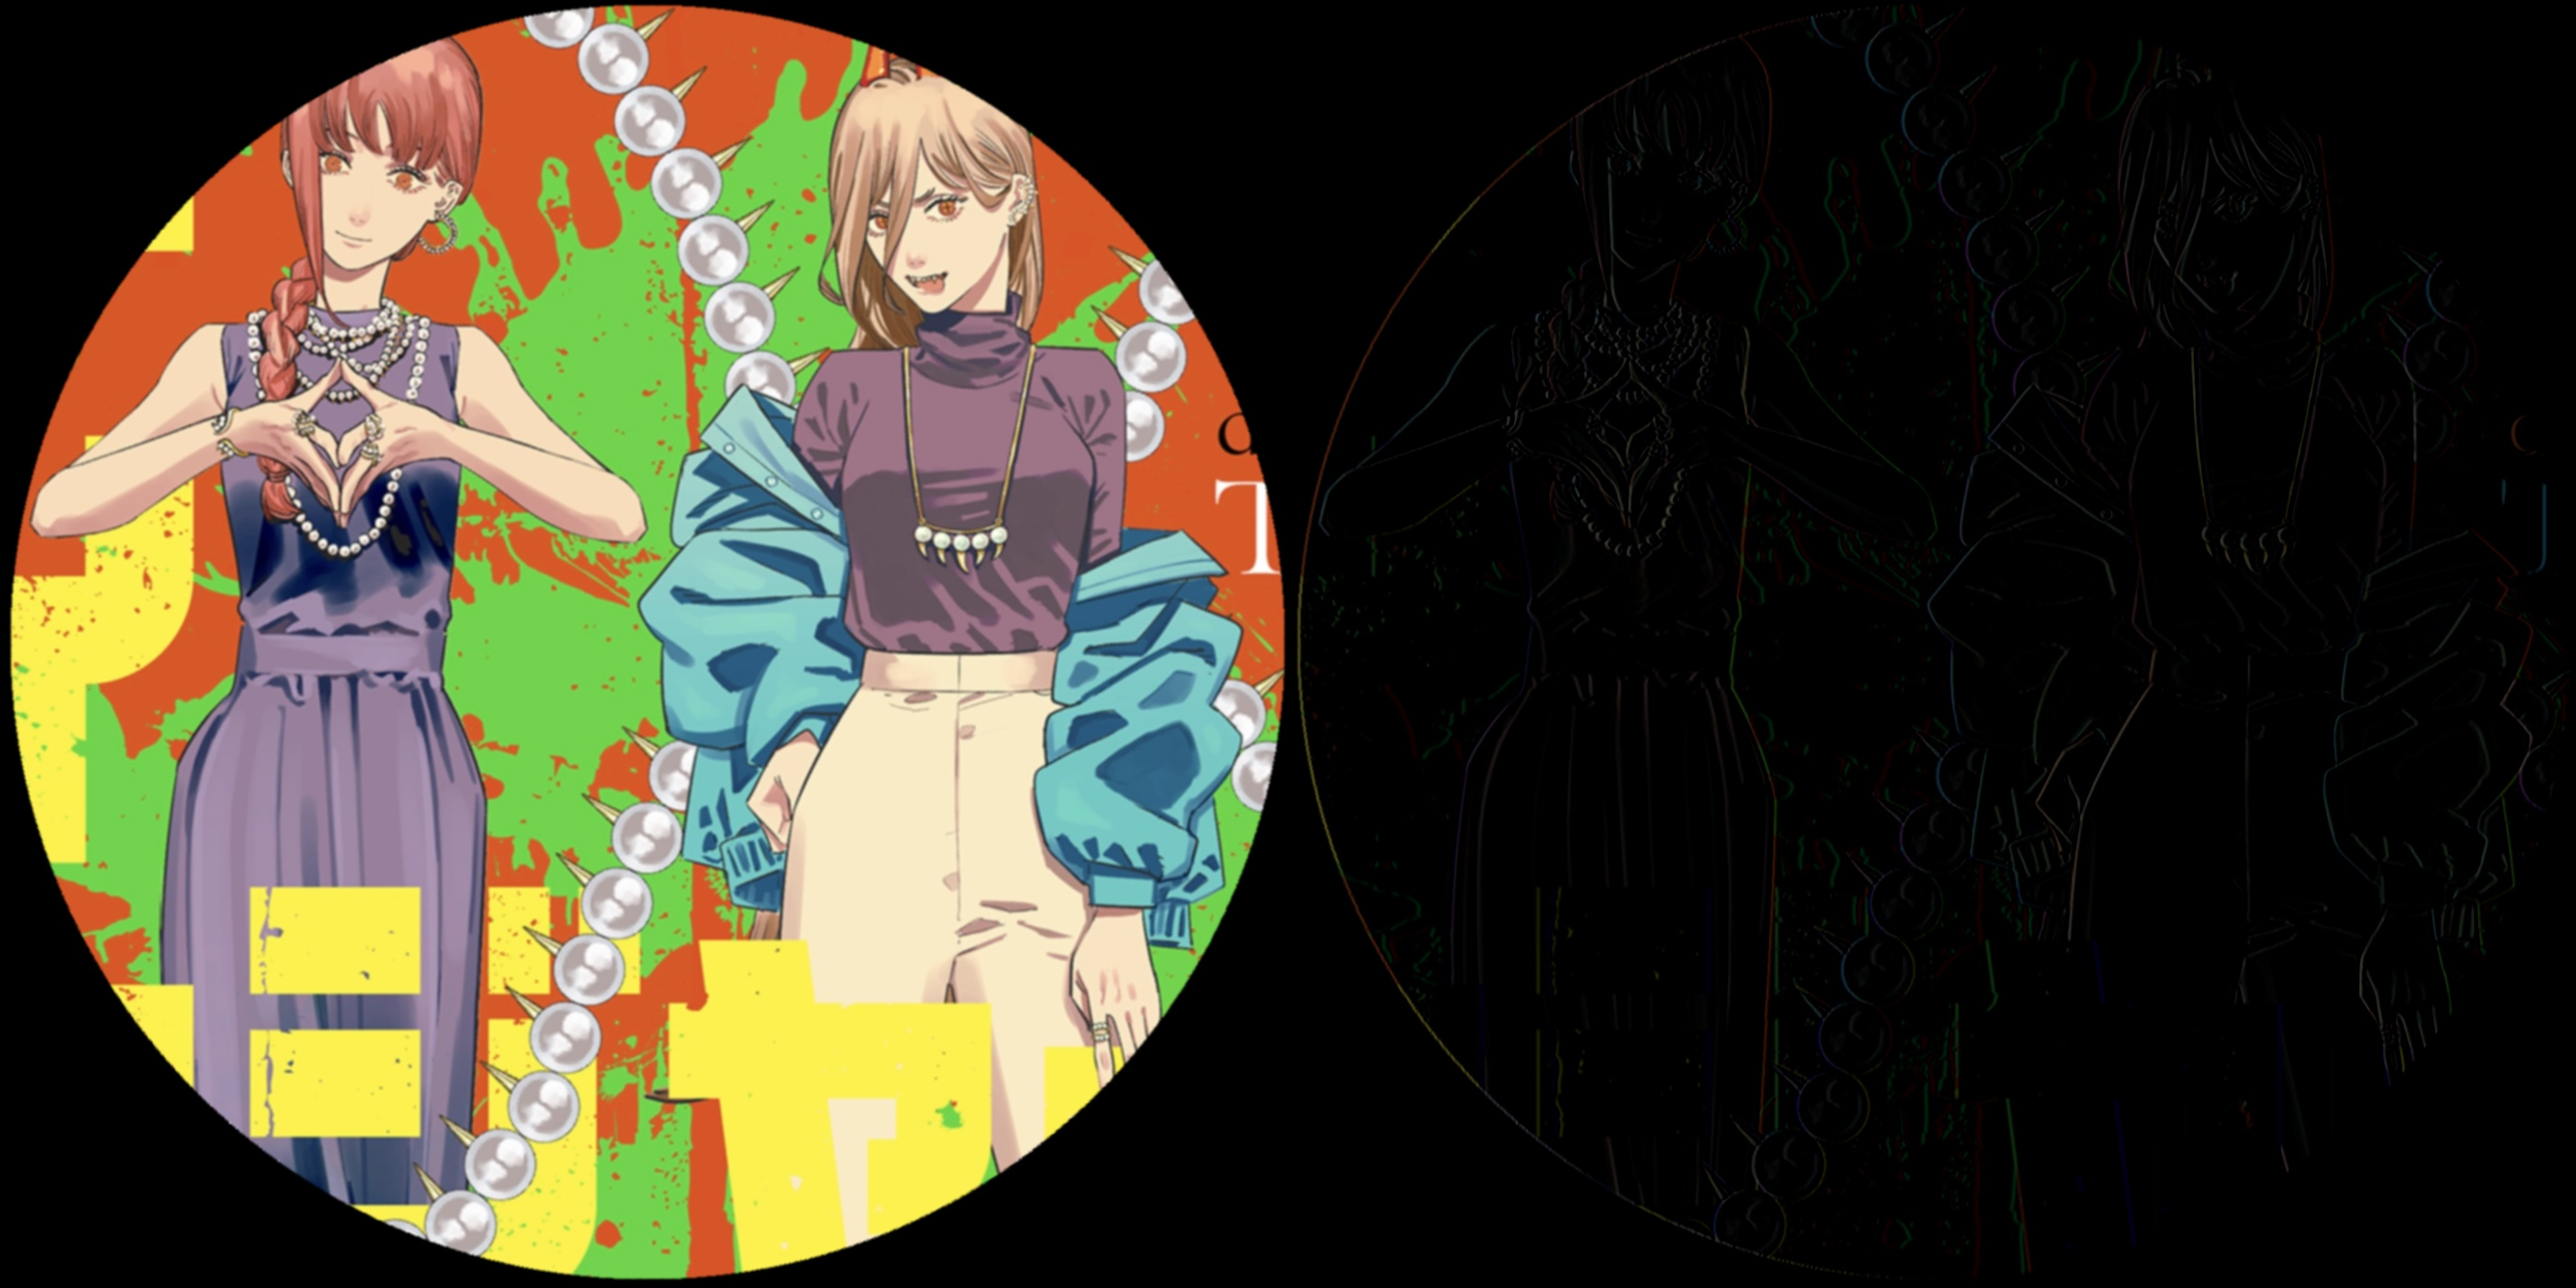

In [ ]:
#x方向の微分
gs=cv2.GaussianBlur(i_dash,(3,3),3)
kernel = 0.5 * np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
dst = cv2.filter2D(gs, -1, kernel)
imgs=cv2.hconcat([gs,dst])

imshow(imgs)

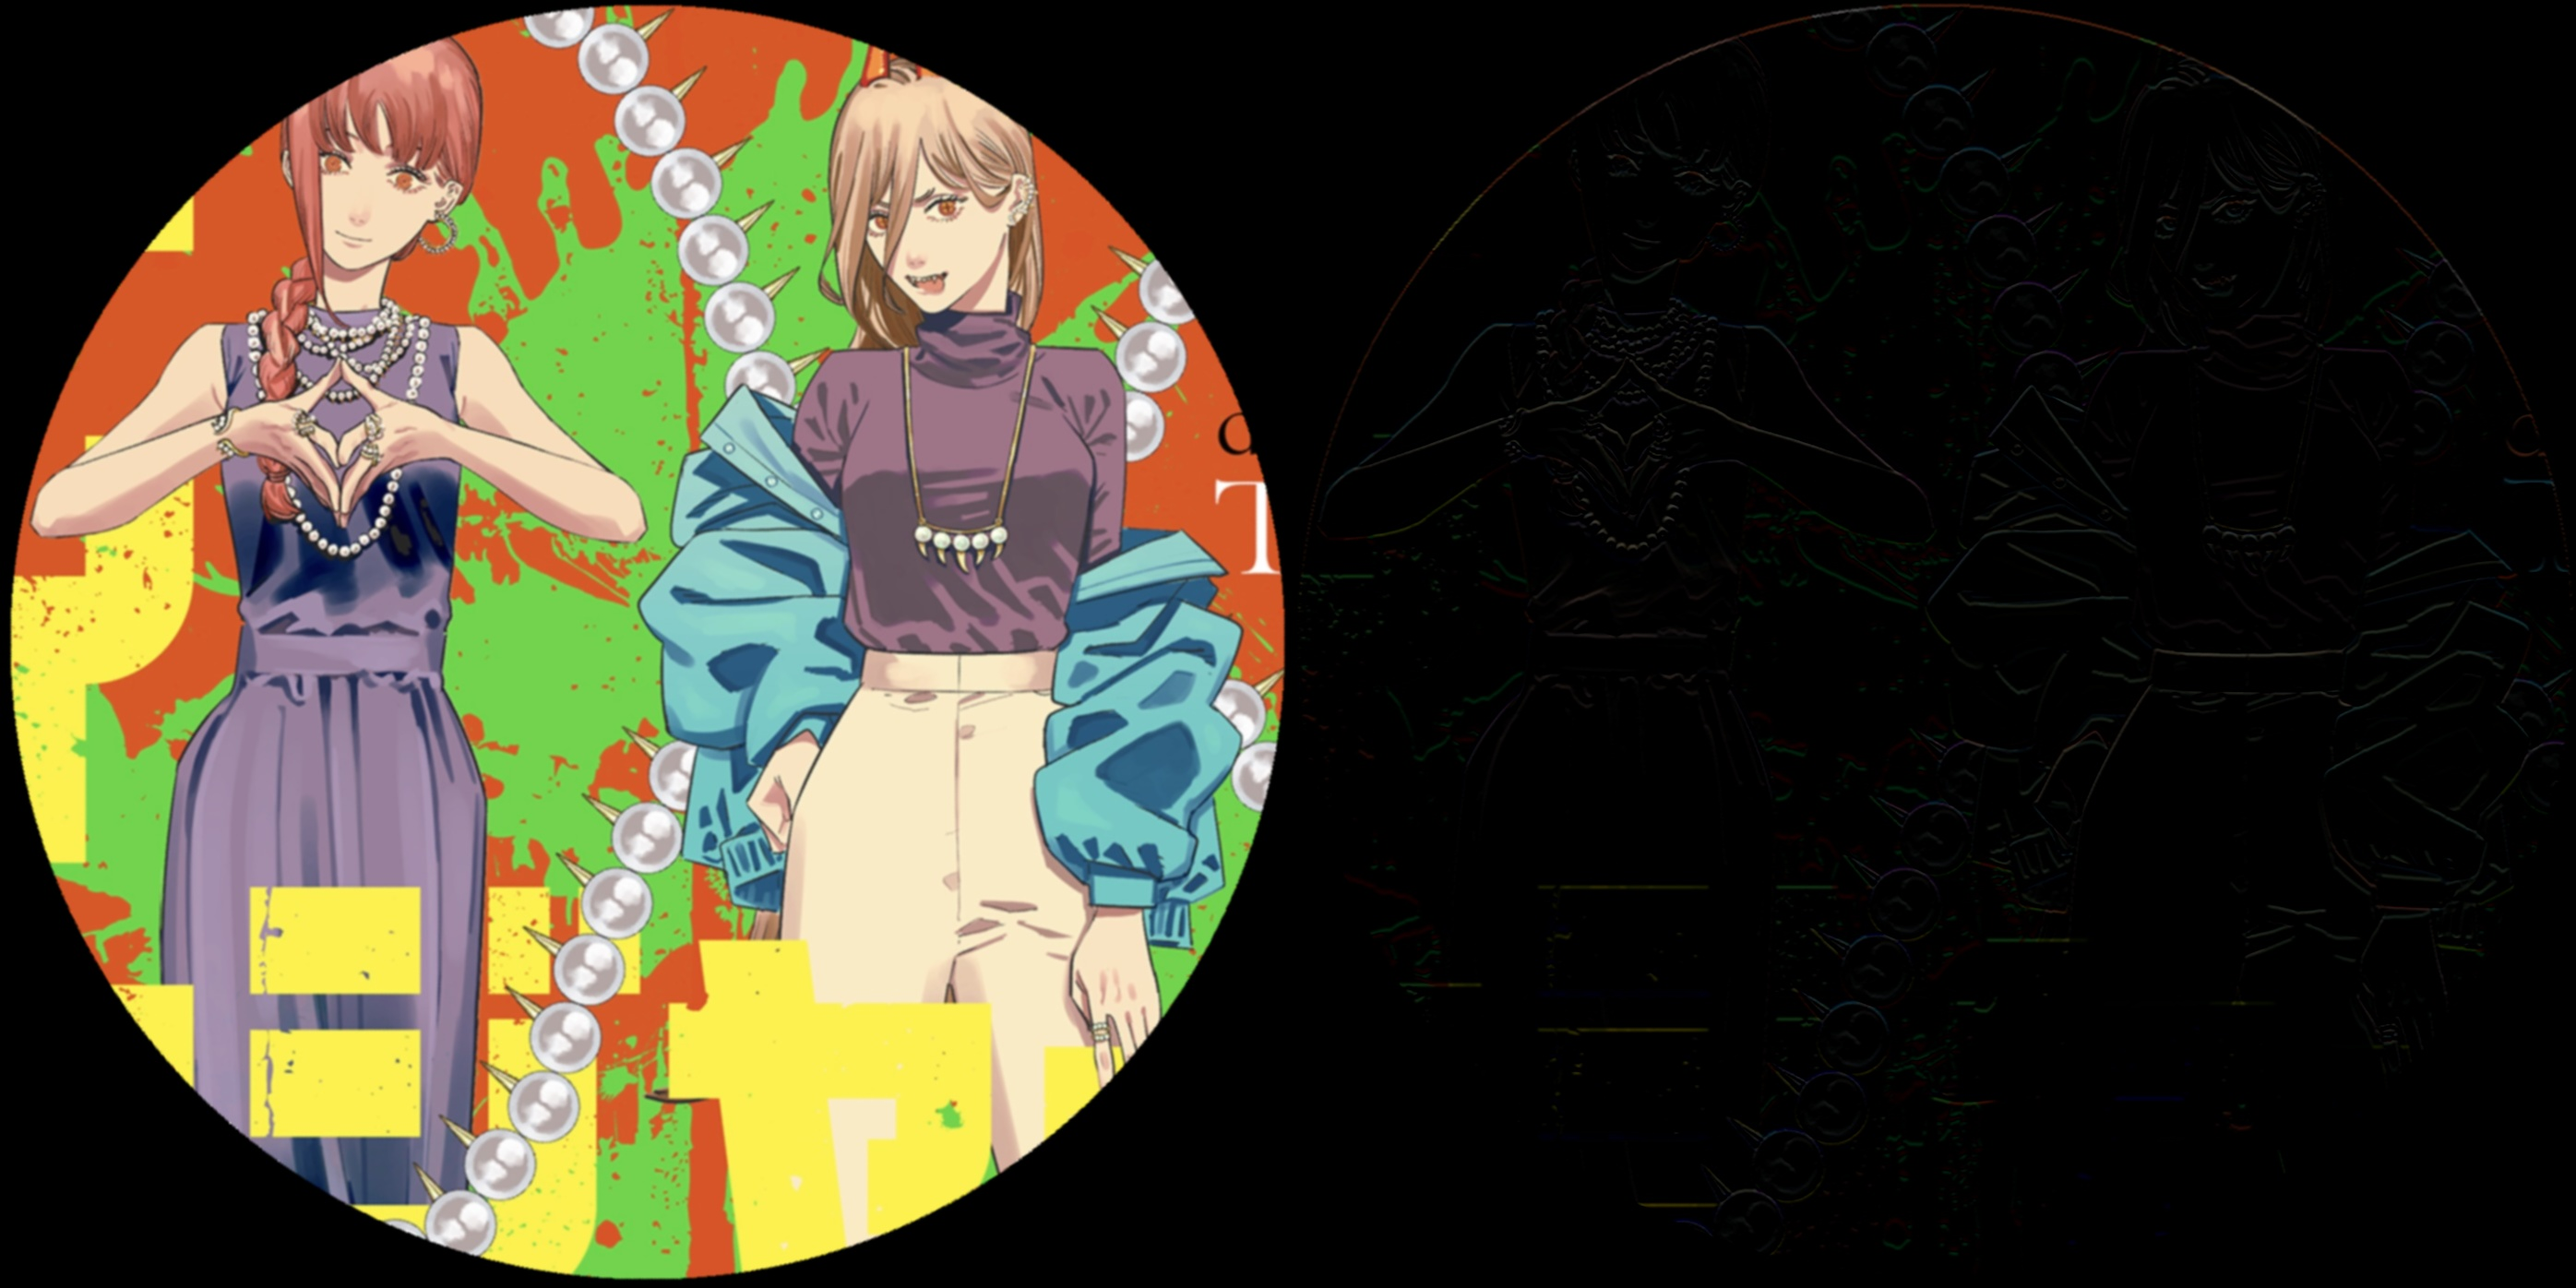

In [ ]:
#y方向の微分
gs=cv2.GaussianBlur(i_dash,(3,3),3)
kernel = 0.5 * np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
dst = cv2.filter2D(gs, -1, kernel)
imgs=cv2.hconcat([gs,dst])

imshow(imgs)

In [85]:
pic_name="pic1.png"
pic_st_name="pic2.png"
scale,theta=0.6,60
orig_img=cv2.imread(pic_name)
tp=TransferedPicture(pic=orig_img,scale=scale,theta=theta)
#画像データを得る
orig_img,st_img=tp.get_img_array()
orig_gray_img,st_gray_img=tp.get_gray_array()
#numpy配列化する
orig_array,st_array=np.array(orig_img),np.array(st_img)
orig_gray_array,st_gray_array=np.array(orig_gray_img),np.array(st_gray_img)

In [86]:
#thetaとscaleの初期値を適当に決める
#theta=random.uniform(-180,180)
#scale=random.random()
scale,theta=1/0.6,-60

#出力画像を逆変換した画像I'に対して平滑微分画像I'_x'、I'_y'を作成する
#orig_array:I, st_array:出力画像
#I'の計算
h,w=st_gray_img.shape
#i_dash_img=TransferedPicture(pic=st_img,scale=1/scale,theta=(-1*theta))
i_dash_img=TransferedPicture(pic=st_gray_img,scale=scale,theta=theta,gray=True)
i_dash_array=np.array(i_dash_img.img)
i_x,i_y=i_dash_img.smooth_def()
i_x_array,i_y_array=np.array(i_x),np.array(i_y)

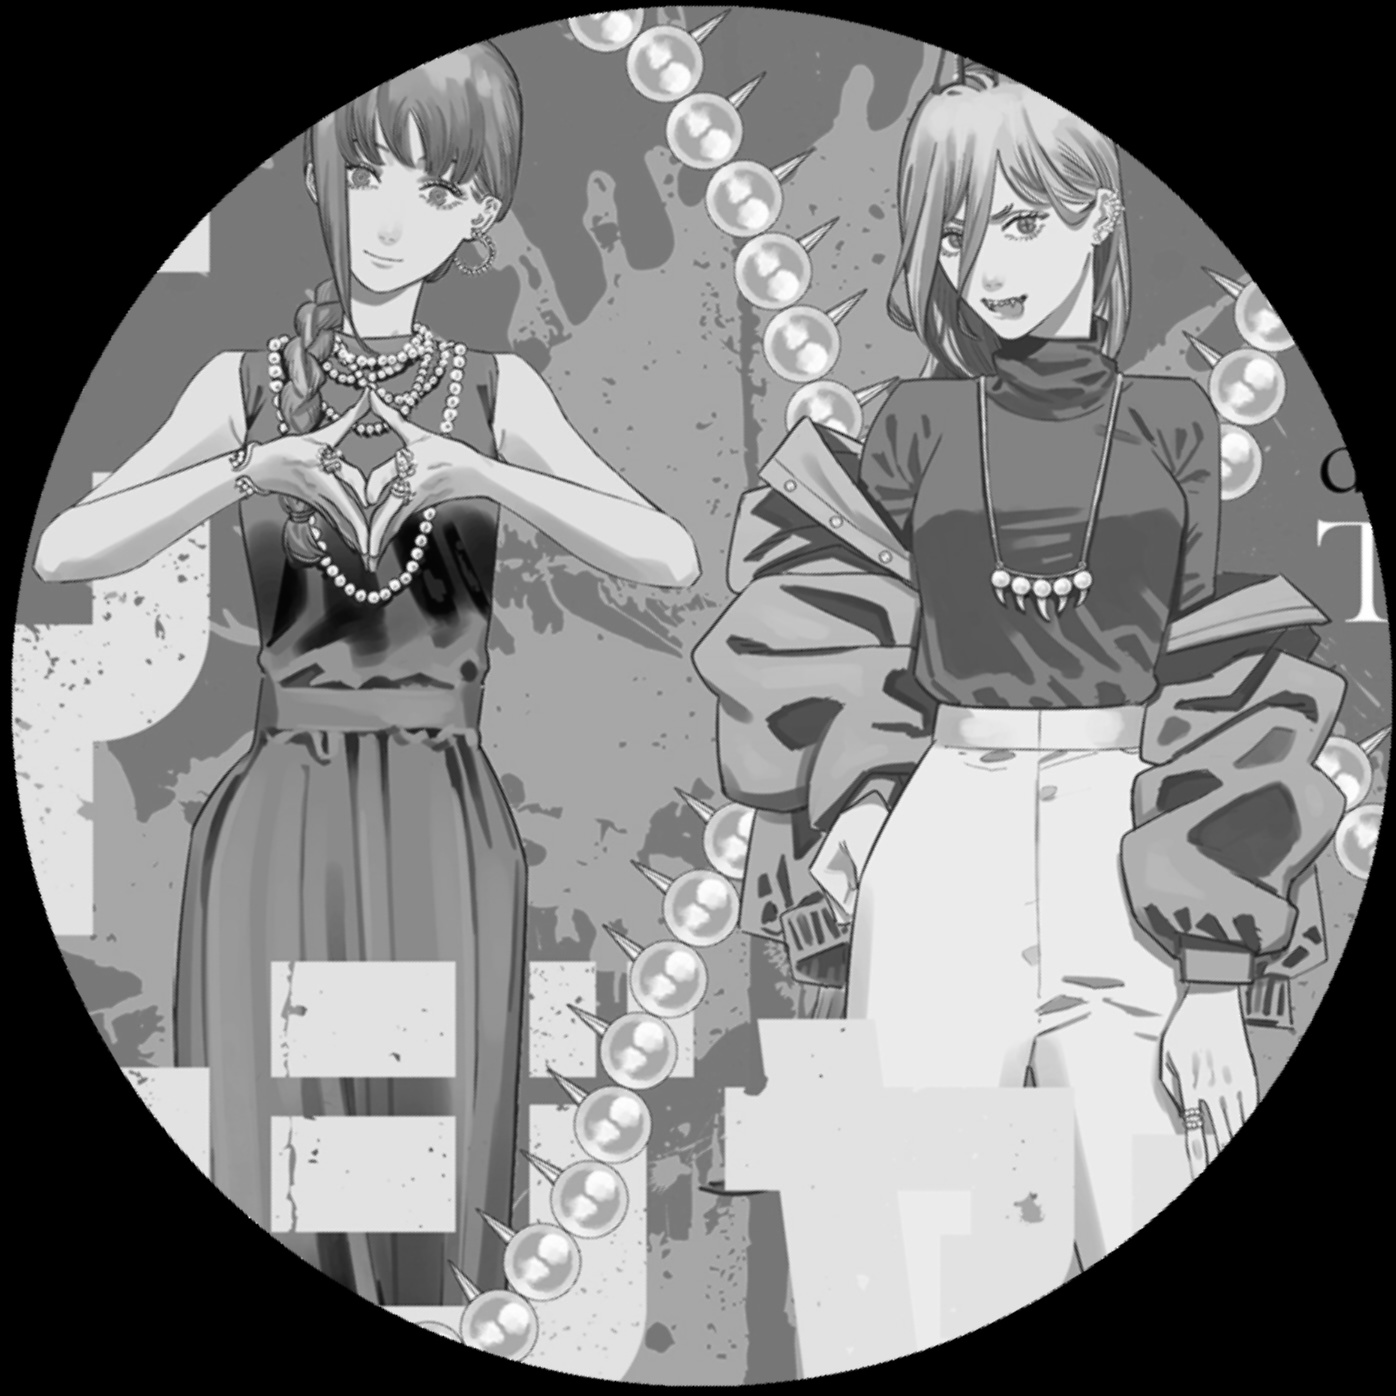

In [113]:
imshow(i_dash_img.img)

In [118]:
def dx_dtheta(x,y,scale,theta):
    return scale*(-2*x*np.sin(theta)-(2*y*np.cos(theta)))
def dy_dtheta(x,y,scale,theta):
    return scale*(2*x*np.cos(theta)-(2*y*np.sin(theta)))
def dx_dscale(x,y,scale,theta):
    return 2*x*np.cos(theta)-(2*y*np.sin(theta))
def dy_dscale(x,y,scale,theta):
    return 2*x*np.sin(theta)-(2*y*np.cos(theta))

#J_thetaを計算
def J_theta(h,w,scale,theta):
    sum=.0
    for x in range(h):
        for y in range(w):
            #x_dとy_dの使い方がわからん
            x_d=scale*(np.cos(theta)*x-(np.sin(theta)*y))
            y_d=scale*(np.sin(theta)*x+np.cos(theta)*y)
            dxdt=dx_dtheta(x_d,y_d,scale,theta)
            dydt=dy_dtheta(x_d,y_d,scale,theta)
            sum+=(i_dash_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))
            
    return sum
j_t=J_theta(h,w,scale,theta)

IndexError: index -1398 is out of bounds for axis 0 with size 1396

In [100]:
j_t

-229498279974.23322

In [111]:
x,y=4,667
dxdt=dx_dtheta(x,y,scale,theta)
dydt=dy_dtheta(x,y,scale,theta)
#(i_dash_array[x][y]-orig_array[x][y]).dot(i_x_array[x][y]*dxdt+(i_y_array[x][y]*dydt))
dxdt,dydt

(2113.4673848416683, -690.3944539894638)

In [115]:
#J_thetathetaを計算
def J_thetatheta(h,w,scale,theta):
    sum=.0
    for x in range(h):
        for y in range(w):
            dxdt=dx_dtheta(x,y,scale,theta)
            dydt=dy_dtheta(x,y,scale,theta)
            sum+=(i_x_array[x][y]*dxdt+(i_y_array[x][y]*dydt))*(i_x_array[x][y]*dxdt+(i_y_array[x][y]*dydt))
    return sum
j_tt=J_thetatheta(h,w,scale,theta)

In [116]:
j_t,j_tt

(-229498279974.23322, 309440635013403.6)

In [8]:
pic_name="pic1.jpeg"
scale,theta=0.6,60
img = cv2.imread(pic_name)
h,w,c=img.shape
mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale)
sim_img = cv2.warpAffine(img, mat, (w, h))
cv2.imwrite('picture.png', sim_img)

True